#Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import urllib
import random
import pandas as pd # Library for data analysis and visualization

#Importing the dataset

In [2]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [3]:
with np.load(fname) as dobj:
    dat = dict(**dobj)

labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

#Data exploration


In [ ]:
print(labels.shape) # 4 rows

print('Example:')
k = 5
print(f'label: {labels[3, k]}: {labels[0, k]} -> {labels[1, k]} -> {labels[2, k]}')

(4, 1750)
Example:
label: starfish: animal -> invertebrate -> echinoderm


In [ ]:
print(val_labels[:, 6:10])

[['animal' 'artifact' 'animal' 'animal']
 ['vertebrate' 'covering' 'vertebrate' 'vertebrate']
 ['amphibian' 'clothing' 'mammal' 'mammal']
 ['common newt' 'trench coat' 'ox' 'gorilla']]


In [ ]:
print(np.unique(labels[0]))

['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant']


In [ ]:
for cat in np.unique(labels[0]):
  print(cat, (labels.T == cat).sum())

animal 589
artifact 812
entity 72
fruit 77
fungus 5
geological formation 192
person 2
plant 1


In [ ]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


Displaying image form stimuli

(1750, 128, 128)
(120, 128, 128)


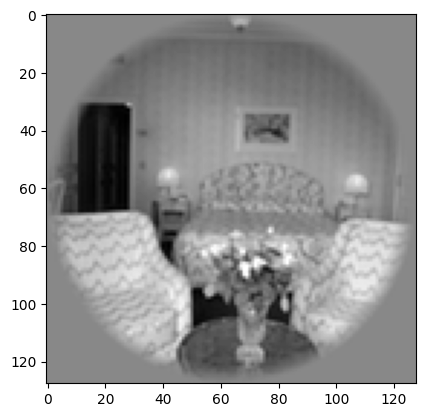

In [ ]:
print(dat["stimuli"].shape) # 1750 images, each 128x128
print(dat["stimuli_test"].shape)

plt.imshow(dat["stimuli"][300], cmap = 'gray')

In [ ]:
print(dat["responses"].shape) # 8428 voxels in total

(1750, 8428)


In [ ]:
print(dat['roi'].shape) # each of the voxels has an associated ROI
print(dat['roi'][20:30])
print(dat['roi_names'][dat['roi'][20:30]]) # ROI has the index of the corresponding region in "roi_names"

(8428,)
[3 3 3 3 3 3 2 2 3 2]
['V3' 'V3' 'V3' 'V3' 'V3' 'V3' 'V2' 'V2' 'V3' 'V2']


In [ ]:
print(np.bincount(dat["roi"])) # How many voxels per region
print(dat["roi_names"]) # all the regions

[   0 1294 2083 1790  484  314 1535  928]
['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']


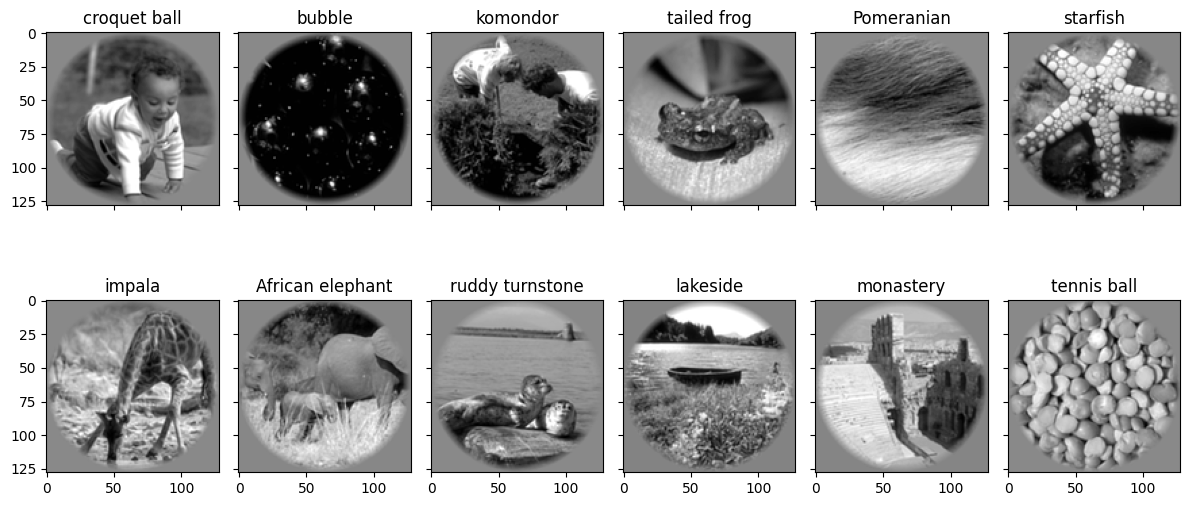

In [ ]:
f, axs = plt.subplots(2, 6, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

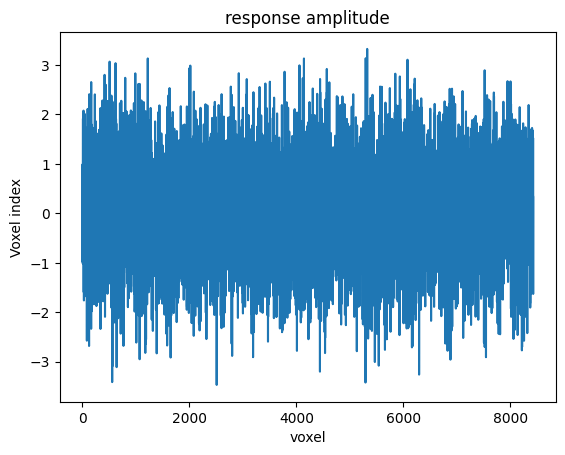

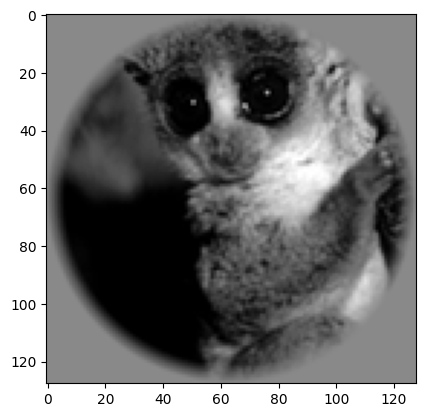

In [ ]:
signal = dat['responses'][200] # Response for stimulis number 8

plt.plot(signal)

plt.xlabel('voxel')
plt.ylabel('Voxel index') # It is given by the z-score of the signal (it's a way of normalization)
plt.title('response amplitude')
plt.figure()
plt.imshow(dat['stimuli'][200], cmap = "gray")


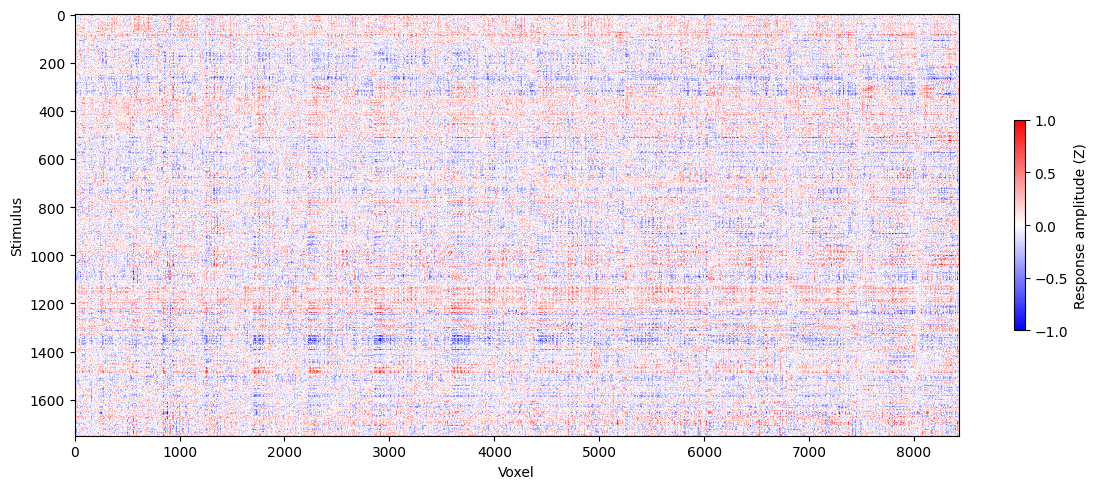

In [ ]:
  f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr") # Shows the
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

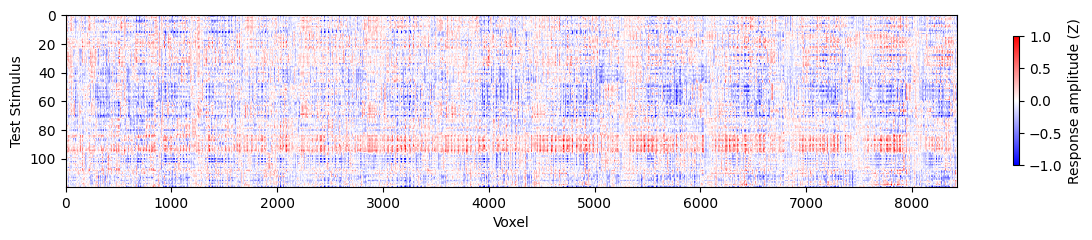

In [ ]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()

#Classification task

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image

In [5]:
dat.keys()

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])

In [6]:
from sklearn.preprocessing import LabelEncoder
lab= LabelEncoder()
label=lab.fit_transform(labels[0])
list(lab.classes_)


['animal',
 'artifact',
 'entity',
 'fruit',
 'fungus',
 'geological formation',
 'person',
 'plant']

In [7]:
np.unique(label)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(dat['stimuli'],label,test_size=0.2, random_state=42)

In [9]:
X_train.shape, y_train.shape

((1400, 128, 128), (1400,))

In [10]:
y_train.shape

(1400,)

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

class CustomDataset(Dataset):
    def __init__(self, images, label):
        self.label = torch.LongTensor(label)
        self.images = images

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label = self.label[idx]
        image = self.images[idx]


        # Apply the specified transform to the image
        image = transform(image)
        return  image, label

In [12]:
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test, y_test)


In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
for x, y in train_loader:
    print(x.shape, y.shape)

torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([5

In [15]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 128, 8192)
        self.fc2 = nn.Linear(8192, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 32)
        self.output_layer = nn.Linear(32, 8)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.softmax(self.output_layer(x), dim=1)
        return x

In [16]:
model1 = CustomModel()


In [17]:
print(model1)

CustomModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=8, bias=True)
)


In [18]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=0.0001)

In [19]:

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for X, y  in train_loader:

        # Check the size of the input data
        # print("Original size:", data.size())

        # Flatten the input image
        # inputs = data

        # Check the size after flattening
        # print("Flattened size:", inputs.size())

        # Instantiate the Autoencoder
        # autoencoder = Autoencoder()

        # Pass the input data to the Autoencoder
        model1.train()
        outputs = model1(X)


        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

                # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += y.size(0)
        correct_predictions += (predicted == y).sum().item()

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.8667, Accuracy: 0.4164
Epoch [1/10], Loss: 1.8990
Epoch [2/10], Loss: 1.8165, Accuracy: 0.4571
Epoch [2/10], Loss: 1.7562
Epoch [3/10], Loss: 1.8172, Accuracy: 0.4571
Epoch [3/10], Loss: 1.8812
Epoch [4/10], Loss: 1.8173, Accuracy: 0.4571
Epoch [4/10], Loss: 1.8990
Epoch [5/10], Loss: 1.8173, Accuracy: 0.4571
Epoch [5/10], Loss: 1.8990
Epoch [6/10], Loss: 1.8170, Accuracy: 0.4571
Epoch [6/10], Loss: 1.8454
Epoch [7/10], Loss: 1.8167, Accuracy: 0.4571
Epoch [7/10], Loss: 1.7919
Epoch [8/10], Loss: 1.8165, Accuracy: 0.4571
Epoch [8/10], Loss: 1.7562
Epoch [9/10], Loss: 1.8170, Accuracy: 0.4571
Epoch [9/10], Loss: 1.8454
Epoch [10/10], Loss: 1.8166, Accuracy: 0.4571
Epoch [10/10], Loss: 1.7740


#Feature extraction and featue vector

In [ ]:
import torchvision.models as tm
import torch
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
nodes, _ = get_graph_node_names(model1)
print(nodes)

['x', 'flatten', 'fc1', 'relu', 'fc2', 'relu_1', 'fc3', 'relu_2', 'fc4', 'relu_3', 'fc5', 'relu_4', 'fc6', 'relu_5', 'output_layer', 'softmax']


In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

feature_extractor = create_feature_extractor(
	model1, return_nodes=['fc4', 'fc5','fc6'])


In [ ]:
dataset_size = dat['stimuli'].shape[0]


class CustomDataset1(torch.utils.data.Dataset):
    def __init__(self):
        self.size = dataset_size

    def __getitem__(self, index):

        # Select image (stimuli)
        im = dat['stimuli'][index]
        preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])


        input_tensor = preprocess(im)
        input_batch = input_tensor
        feature_extractor = create_feature_extractor(
        model1, return_nodes=[ 'fc6'])
        out = feature_extractor(input_batch)
        y = out['fc6'].detach().squeeze()
        # Select vector of voxels
        responses = torch.Tensor(dat['responses'][index])

        return responses.squeeze(0), y
    def __len__(self):
        return self.size


In [ ]:
#  using the prebuilt data loader.
custom_dataset = CustomDataset1()
train_loader1 = torch.utils.data.DataLoader(dataset=custom_dataset, batch_size=64,shuffle=True)

#Deocder

In [ ]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 3000
num_epochs = 5
learning_rate = 0.001

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
model = Decoder(8428, hidden_size, 32).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader1)
for epoch in range(num_epochs):
    for i, (voxels, afeatures) in enumerate(train_loader1):
        # Move tensors to the configured device
        voxels = voxels.to(device)
        afeatures = afeatures.to(device)

        # Forward pass
        outputs = model(voxels)
        loss = criterion(outputs, afeatures)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [10/28], Loss: 1.5279
Epoch [1/5], Step [20/28], Loss: 0.9504
Epoch [2/5], Step [10/28], Loss: 1.6224
Epoch [2/5], Step [20/28], Loss: 0.9880
Epoch [3/5], Step [10/28], Loss: 1.0123
Epoch [3/5], Step [20/28], Loss: 0.6548
Epoch [4/5], Step [10/28], Loss: 0.6012
Epoch [4/5], Step [20/28], Loss: 0.3921
Epoch [5/5], Step [10/28], Loss: 0.2350
Epoch [5/5], Step [20/28], Loss: 0.1406


#Classification model with responses and Labels

In [ ]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1= train_test_split(dat['responses'],label,test_size=0.2, random_state=42)

In [ ]:
X_train1.shape

(1400, 8428)

In [ ]:
y_train1.shape

(1400,)

In [240]:

class CustomDataset2(Dataset):
    def __init__(self, responses, label):
        self.label = torch.LongTensor(label)
        self.responses = responses

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label = self.label[idx]
        response = self.responses[idx]
        response = torch.FloatTensor(response)


        # Apply the specified transform to the response
        response = model(response)

        return  response.squeeze(dim = 0).flatten(), label

In [241]:
train_dataset1 = CustomDataset2(X_train1,y_train1)
test_dataset1 = CustomDataset2(X_test1, y_test1)

In [242]:
train_loader2 = DataLoader(train_dataset1, batch_size=1, shuffle=True)
test_loader2 = DataLoader(test_dataset1, batch_size=1, shuffle=False)

In [ ]:
for x, y in train_loader2:
  print(X.shape, y.shape)

In [244]:
class CustomModel1(nn.Module):
    def __init__(self):
        super(CustomModel1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32,28)
        self.fc2 = nn.Linear(28, 16)
        self.fc3 = nn.Linear(16, 10)
        self.output_layer = nn.Linear(10, 8)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.output_layer(x), dim=1)
        return x

In [245]:
model2 = CustomModel1()

In [246]:
print(model2)

CustomModel1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=8, bias=True)
)


In [247]:
  # Define the loss function and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model2.parameters(),lr=0.0001)

In [ ]:

num_epochs = 10
for epoch in range(num_epochs):
    for X, y  in train_loader1:

        # Check the size of the input data
        # print("Original size:", data.size())

        # Flatten the input image
        # inputs = data

        # Check the size after flattening
        # print("Flattened size:", inputs.size())

        # Instantiate the Autoencoder
        # autoencoder = Autoencoder()
        print(X.shape)
        # Pass the input data to the Autoencoder
        model2.train()
        outputs = model2(X)



        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


#Creating custom dataset For auto encoder

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

class CustomDataset(Dataset):
    def __init__(self, response, image):
        self.response = torch.tensor(response, dtype=torch.float32)
        self.image = image

    def __len__(self):
        return len(self.response)

    def __getitem__(self, idx):
        response = self.response[idx]
        image = self.image[idx]

        image = transform(image)

        # Unsqueeze along the first dimension
        # sample = response.unsqueeze(0)

        return response, image.squeeze(dim = 0).flatten()

In [ ]:
custom_dataset = CustomDataset(dat['responses'], dat['stimuli'])

# Accessing a sample
sample = custom_dataset[0]


In [ ]:
len(custom_dataset)

1750

In [ ]:
# Create a DataLoader for the CustomDataset
data_loader = DataLoader(custom_dataset, shuffle=True)

In [ ]:
for x, y in data_loader:
    print(x.shape, y.shape)

#Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
       	self.encoder = torch.nn.Sequential(
			        torch.nn.Linear(8428, 4096),
			        torch.nn.ReLU(),
			        torch.nn.Linear(4096, 64),
		      )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128*128),
            nn.Sigmoid()  # Sigmoid to ensure output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = Autoencoder()
print(autoencoder)
# Instantiate the model
model = Autoencoder()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8428, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16384, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
custom_dataset = CustomDataset(dat['responses'], dat['stimuli'])
data_loader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

# Instantiate the autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# from torchvision import models
# models.Alexnet

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y  in data_loader:

        # Check the size of the input data
        # print("Original size:", data.size())

        # Flatten the input image
        # inputs = data

        # Check the size after flattening
        # print("Flattened size:", inputs.size())

        # Instantiate the Autoencoder
        # autoencoder = Autoencoder()

        # Pass the input data to the Autoencoder
        model.train()
        outputs = model(X)



        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 2.4506
Epoch [2/10], Loss: 1.9877
Epoch [3/10], Loss: 1.7836
Epoch [4/10], Loss: 1.6345
Epoch [5/10], Loss: 1.6073
Epoch [6/10], Loss: 1.5609
Epoch [7/10], Loss: 1.5009
Epoch [8/10], Loss: 1.4541
Epoch [9/10], Loss: 1.5410
Epoch [10/10], Loss: 1.5101


##reconstructed image

torch.Size([16384])


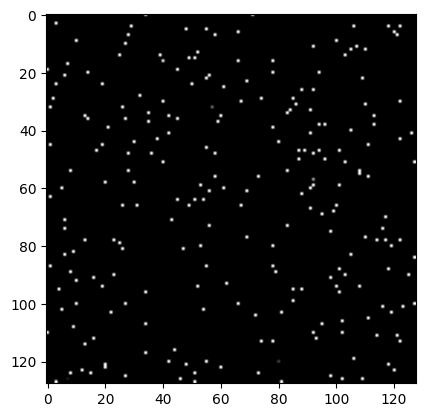

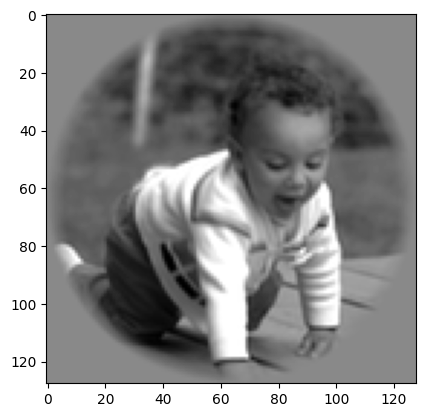

In [ ]:
model.eval()
with torch.inference_mode():
    # Take a sample from the dataset
    # sample = custom_dataset[0].view(-1, 128*128).float()
    # Use the autoencoder to get the reconstructed sample
    # reconstructed_sample = Autoencoder(sample)
    for X, y in custom_dataset:
      output = model(X)
      print(output.shape)
      plt.imshow(output.reshape((128, 128)), cmap = 'gray')
      plt.show()
      plt.imshow(y.reshape((128, 128)), cmap = 'gray')
      plt.show()
      break